<a href="https://colab.research.google.com/github/arthursl12/MIR/blob/master/Lab07/Lab07_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Descomente para executar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-kjyfjow4
  Running command git clone -q https://github.com/flaviovdf/musica.git /tmp/pip-req-build-kjyfjow4
     |████████████████████████████████| 176 kB 10.4 MB/s 
     |████████████████████████████████| 126 kB 40.6 MB/s 
     |████████████████████████████████| 65 kB 3.1 MB/s 
  Created wheel for musica-dcc-ufmg: filename=musica_dcc_ufmg-0.1-py3-none-any.whl size=3414 sha256=78b2a50b03c8921c57cb9251e56e17a156304bb9de53408f3e7bd12e101ede8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8sy44388/wheels/94/cb/e0/72e4ee72153bf78a970722ac92a93e8a8f31c1853e32a3d1bc
Successfully built musica-dcc-ufmg


# Music Auto Tagging (Multi-Label Classification and Metric Learning Approach)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems. 

Two central methods for representation learning include deep metric learning and classification, both having the same goal of learning a representation that can generalize well across tasks.

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

## Importing Packages

In [2]:
from μsica import μsf
from μsica import μsp

from glob import glob

# import flax.linen as nn
# import jax.numpy as jnp
# import jax
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

import librosa
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import pandas as pd
import IPython.display as ipd

In [3]:
# Descomente para baixar novamente
μsf.download('https://dcc.ufmg.br/~flaviovdf/mir/lab07/files.zip', 'files.zip',False)
μsf.extract('files.zip', '.')

files.zip: 300MB [00:45, 6.98MB/s]


In [4]:
μsp.init_matplotlib()
plt.ion()

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [5]:
df = pd.read_csv('subset_magnatune.csv', index_col=0)
df.shape

(1048, 189)

In [6]:
df.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,sitar,chorus,female opera,male vocal,vocals,clarinet,heavy,silence,beats,men,woodwind,funky,no strings,chimes,foreign,no piano,horns,classical,female,no voices,soft rock,eerie,spacey,jazz,guitar,quiet,no beat,banjo,electric,solo,...,scary,india,woman,woman singing,rock,dance,piano solo,guitars,no drums,jazzy,singing,cello,calm,female vocals,voices,different,techno,clapping,house,monks,flute,not opera,not english,oriental,beat,upbeat,soft,noise,choir,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0/rocket_city_riot-last_of_the_pleasure_seeker...
293,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-59-88.npy
294,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-88-117.npy
303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1/ambient_teknology-phoenix-01-ambient_teknolo...


[Text(0, 0.5, 'Frequência')]

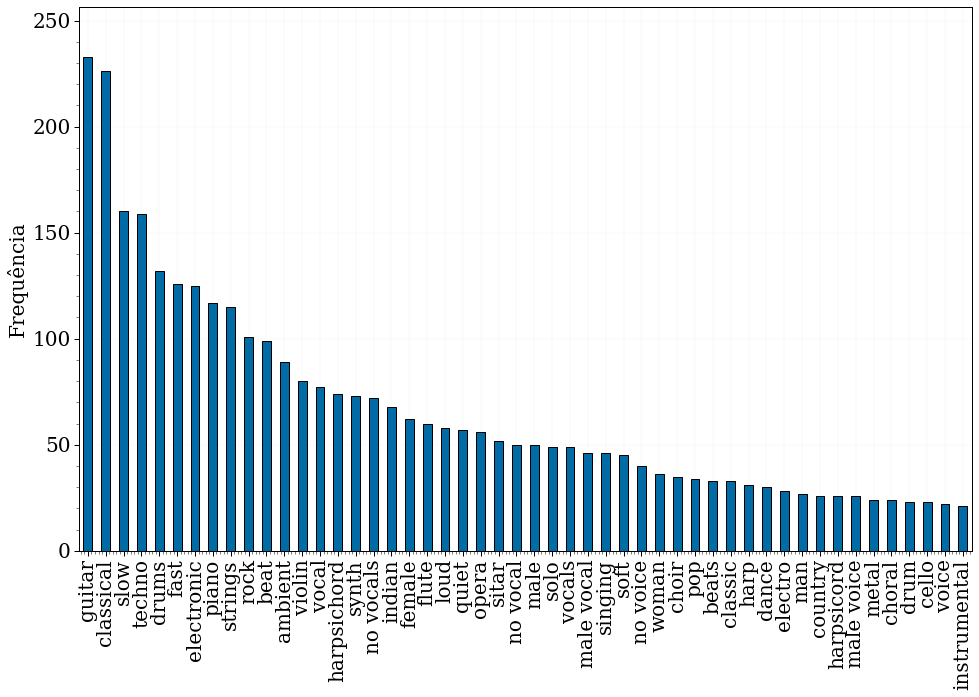

In [7]:
_, ax = plt.subplots(1, 1)
(df.iloc[:, :-1].sum().
 sort_values(ascending=False)[:50].
 plot.bar(ax=ax, rot=90, edgecolor='k')
)
ax.set(ylabel='Frequência')

In [8]:
top = (df.iloc[:, :-1].sum().
       sort_values(ascending=False)[:50]).index
top

Index(['guitar', 'classical', 'slow', 'techno', 'drums', 'fast', 'electronic',
       'piano', 'strings', 'rock', 'beat', 'ambient', 'violin', 'vocal',
       'harpsichord', 'synth', 'no vocals', 'indian', 'female', 'flute',
       'loud', 'quiet', 'opera', 'sitar', 'no vocal', 'male', 'solo', 'vocals',
       'male vocal', 'singing', 'soft', 'no voice', 'woman', 'choir', 'pop',
       'beats', 'classic', 'harp', 'dance', 'electro', 'man', 'country',
       'harpsicord', 'male voice', 'metal', 'choral', 'drum', 'cello', 'voice',
       'instrumental'],
      dtype='object')

In [9]:
df = df[[c for c in top] + ['mp3_path']]
df.shape

(1048, 51)

In [10]:
(df.sum(axis=1) == 0).any()

True

In [11]:
df = df[df.sum(axis=1) != 0]
df = df.sample(frac=1)
df.head()

,guitar,classical,slow,techno,drums,fast,electronic,piano,strings,rock,beat,ambient,violin,vocal,harpsichord,synth,no vocals,indian,female,flute,loud,quiet,opera,sitar,no vocal,male,solo,vocals,male vocal,singing,soft,no voice,woman,choir,pop,beats,classic,harp,dance,electro,man,country,harpsicord,male voice,metal,choral,drum,cello,voice,instrumental,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32727,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1/richard_savino-murcia__danza_y_diferencias-0...
6430,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a/edward_martin_and_william_bastian-virtues_an...
31890,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c/soulprint-in_spite_of_it_all-07-inside-30-59...
39324,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b/richard_savino-mertz__bardic_sounds-09-gondo...
3064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2/indidginus-as_above_so_below-01-obsidian-117...


In [12]:
train_df = df[:768]
val_df = df[768:896]
test_df = df[896:896+128]

print(train_df.shape, val_df.shape, test_df.shape)

(768, 51) (128, 51) (128, 51)


# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [13]:
def to_mel_spectrum(wave, sr=16000, n_fft=516, n_mels=96, secs=6):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [14]:
def load_data(file_paths):
    for fpath in file_paths:
        fpath = os.path.join('waveform', fpath)
        yield np.load(fpath)

In [15]:
data_train = list(map(to_mel_spectrum, load_data(train_df['mp3_path'])))
X_train = np.array(data_train)
Y_train = np.array(train_df.drop('mp3_path', axis=1).values)

data_val = list(map(to_mel_spectrum, load_data(val_df['mp3_path'])))
X_val = np.array(data_val)
Y_val = np.array(val_df.drop('mp3_path', axis=1).values)

data_test = list(map(to_mel_spectrum, load_data(test_df['mp3_path'])))
X_test = np.array(data_test)
Y_test = np.array(test_df.drop('mp3_path', axis=1).values)

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

In [16]:
keras.backend.clear_session()

num_classes = 50
input_shape = (96, 188, 1)
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        # Layer 1
        layers.ZeroPadding2D(padding=(1, 3), data_format=None),
        layers.Conv2D(96, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        
        # Layer 2
        layers.ZeroPadding2D(padding=(1, 2), data_format=None),
        layers.Conv2D(96, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(1, 3)),
        
        # Layer 3
        layers.ZeroPadding2D(padding=(1, 2), data_format=None),
        layers.Conv2D(96, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(1, 3)),

        # Dense Layer
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(num_classes, activation=tf.nn.log_softmax),
    ]
)

# model.summary()

In [17]:
def cross_entropy_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return -keras.backend.mean(keras.backend.sum(y_true * y_pred, axis=-1))

In [18]:
batch_size = 16
epochs = 5

model.compile(loss=cross_entropy_loss, optimizer="sgd", metrics=["categorical_accuracy"])
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

Epoch 1/5
48/48 [==============================] - 39s 799ms/step - loss: 13.1485 - top_k_categorical_accuracy: 0.4102 - val_loss: 11.6523 - val_top_k_categorical_accuracy: 0.3672
Epoch 2/5
48/48 [==============================] - 41s 849ms/step - loss: 11.7008 - top_k_categorical_accuracy: 0.5664 - val_loss: 11.2099 - val_top_k_categorical_accuracy: 0.6406
Epoch 3/5
48/48 [==============================] - 38s 802ms/step - loss: 11.4945 - top_k_categorical_accuracy: 0.6237 - val_loss: 10.9792 - val_top_k_categorical_accuracy: 0.6484
Epoch 4/5
48/48 [==============================] - 47s 978ms/step - loss: 11.3479 - top_k_categorical_accuracy: 0.5951 - val_loss: 10.8506 - val_top_k_categorical_accuracy: 0.6719
Epoch 5/5
48/48 [==============================] - 38s 786ms/step - loss: 11.2934 - top_k_categorical_accuracy: 0.6289 - val_loss: 11.2028 - val_top_k_categorical_accuracy: 0.4609


## Métricas de Precisão e Desempenho

In [19]:
def auto_tagging(id, df, X, model, topk=5):
    row = df.iloc[id].copy()
    audio_sample = [row['mp3_path']]
    row = row.drop('mp3_path')
    wave = next(load_data(audio_sample))
    X = np.array([X[id]])

    logit = model.predict(X)
    idx = logit.argsort().reshape(-1)[-topk:]
    
    return wave, row[idx].index

In [20]:
import IPython.display as ipd

id = 42
wave, tags = auto_tagging(id, test_df, X_test, model, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['drums', 'beat', 'indian', 'techno', 'slow'], dtype='object')


A métrica de precisão usada pelo Tensorflow/Keras é "binária", ou seja, ou todos as categorias previstas estão corretas para uma mesma amostra ou não, não há nuance. Assim, vamos implementar uma segunda métrica de acurácia que leva em conta a corretude, ainda que parcial, das classes reportadas.

In [21]:
from tensorflow.keras.utils import to_categorical 

def partial_accuracy(Y_pred, Y_true, topk=5, num_classes=50):
    # Find most relevant predicted categories
    idx = tf.argsort(Y_pred)
    new_idx = []
    for i in range(idx.shape[0]):
        new_idx.append(idx[i][-topk:])
    new_idx = np.array(new_idx)

    # One-hot encoding
    cat = tf.one_hot(new_idx, depth=num_classes)
    new = []
    for i in range(cat.shape[0]):
        s = np.sum(cat[i], axis=0)
        new.append(s)
    new = np.array(new)

    # Compute accuracy
    s = np.sum(Y_true == new, axis=1)
    s = s / num_classes
    s = np.mean(s)
    return s

In [22]:
arr = np.array(X_val)
y_pred = model.predict(arr)
partial_accuracy(y_pred, Y_val)

0.87640625

### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings! 

#### Parâmetros do Espectrograma

Temos que fazer uma pequna modificação para incluir o canal nos dados.

In [23]:
def to_mel_spectrum(wave, sr=16000, n_fft=516, n_mels=96, hop=512, secs=6):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       hop_length=hop,
                                       n_mels=n_mels)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [24]:
def mel_only(dataframe):
    data_mel = np.array(list(map(to_mel_spectrum, load_data(dataframe['mp3_path']))))
    X = data_mel.reshape((data_mel.shape[0],data_mel.shape[1],data_mel.shape[2],1))
    Y = Y_train = np.array(dataframe.drop('mp3_path', axis=1).values)
    return X,Y

In [25]:
X_train, Y_train = mel_only(train_df)
X_val, Y_val = mel_only(val_df)
X_test, Y_test = mel_only(test_df)

In [26]:
X_train.shape, Y_train.shape

((768, 96, 188, 1), (768, 50))

#### Arquitetura

In [27]:
keras.backend.clear_session()
num_classes = 50
input_shape = (96, 188, 1)
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        # Layer 1
        layers.ZeroPadding2D(padding=(1, 1), data_format=None),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        
        # Layer 2
        layers.ZeroPadding2D(padding=(1, 1), data_format=None),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        
        # Layer 3
        layers.ZeroPadding2D(padding=(1, 2), data_format=None),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        
        # Layer 4
        layers.ZeroPadding2D(padding=(1, 3), data_format=None),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 5)),
        
        
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(num_classes, activation=tf.nn.log_softmax),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_3 (ZeroPaddi  (None, 98, 190, 1)       0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 188, 64)       640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 47, 64)       0         
 2D)                                                             
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 26, 49, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 47, 128)       73856     
                                                      

In [29]:
batch_size = 16
epochs = 5

model.compile(loss=cross_entropy_loss, optimizer="sgd", metrics=["categorical_accuracy"])
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

Epoch 1/5
48/48 [==============================] - 30s 606ms/step - loss: 13.0512 - categorical_accuracy: 0.2031 - val_loss: 11.1980 - val_categorical_accuracy: 0.3125
Epoch 2/5
48/48 [==============================] - 22s 461ms/step - loss: 11.4939 - categorical_accuracy: 0.2526 - val_loss: 10.6989 - val_categorical_accuracy: 0.2500
Epoch 3/5
48/48 [==============================] - 21s 446ms/step - loss: 11.1151 - categorical_accuracy: 0.2734 - val_loss: 10.6203 - val_categorical_accuracy: 0.1250
Epoch 4/5
48/48 [==============================] - 19s 405ms/step - loss: 10.9317 - categorical_accuracy: 0.2396 - val_loss: 10.3959 - val_categorical_accuracy: 0.3125
Epoch 5/5
48/48 [==============================] - 19s 405ms/step - loss: 10.7544 - categorical_accuracy: 0.2604 - val_loss: 10.2289 - val_categorical_accuracy: 0.2422


#### Desempenho

Essa arquitetura apresenta um desempenho um pouco melhor se comparada à proposta antes. No mesmo caso de exemplo, temos uma melhor identificação dos instrumentos.

In [31]:
import IPython.display as ipd

id = 42
wave, tags = auto_tagging(id, test_df, X_test, model, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['violin', 'guitar', 'strings', 'slow', 'classical'], dtype='object')


In [32]:
arr = np.array(X_val)
y_pred = model.predict(arr)
partial_accuracy(y_pred, Y_val)

0.89109375

### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size 
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...). 

* You can also use ResNet or other CNNs with skip connections. 

* Furthermore, you can augment data using digital audio effects.

#### Parâmetros do Espectrograma

In [33]:
# hop_length = 257 => 499 colunas
def to_mel_spectrum(wave, sr=16000, n_fft=576, n_mels=96, secs=8):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels,
                                       hop_length=257)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [34]:
def mel(dataframe):
    data_mel = np.array(list(map(to_mel_spectrum, load_data(dataframe['mp3_path']))))
    X = data_mel.reshape((data_mel.shape[0],data_mel.shape[1],data_mel.shape[2],1))
    Y = Y_train = np.array(dataframe.drop('mp3_path', axis=1).values)
    return X,Y

In [35]:
X_train, Y_train = mel(train_df)
X_val, Y_val = mel(val_df)
X_test, Y_test = mel(test_df)

In [36]:
X_train.shape, Y_train.shape

((768, 96, 499, 1), (768, 50))

#### Arquitetura

In [37]:
keras.backend.clear_session()
num_classes = 50
input_shape = (96, 499, 1)
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        # Layer 1
        layers.Dropout(0.2),
        layers.ZeroPadding2D(padding=(1, 1), data_format=None),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        layers.Dropout(0.3),
        
        # Layer 2
        layers.ZeroPadding2D(padding=(1, 1), data_format=None),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Dropout(0.3),
    
        
        # Layer 3
        layers.ZeroPadding2D(padding=(1, 2), data_format=None),
        layers.Conv2D(768, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Dropout(0.3),
        
        # Layer 4
        layers.ZeroPadding2D(padding=(1, 0), data_format=None),
        layers.Conv2D(2048, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 7)),
        
        
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dropout(0.4),
        layers.Dense(2048, activation="relu"),
        #layers.LeakyReLU(),
        layers.Dense(num_classes, activation=tf.nn.log_softmax)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 96, 499, 1)        0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 98, 501, 1)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 96, 499, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 124, 128)     0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 24, 124, 128)      0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 26, 126, 128)     0

In [ ]:
# Callbacksde EarlyStopping para evitar overfitting
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', 
                     mode='max', verbose=0,save_best_only=True)

In [ ]:
batch_size = 32
epochs = 30
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=cross_entropy_loss, optimizer=opt, metrics=["categorical_accuracy"])
model.fit(X_train, Y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_data=(X_val, Y_val),
          callbacks=[es,mc],
         verbose='auto')

As grandes mudanças na arquitetura feitas foram:

* Tamanho da entrada: mudou-se o *hop_length* para aumentar a granularidade do espectrograma, aumentando, de fato, a quantidade de colunas, na esperança de obter mais informação. Com isso, foram adaptações no tamanho dos filtros e das camadas de pooling da parte convolucional da rede para abarcar esse novo formato de entrada.
* Quantidade de filtros em cada camada: há bem mais filtros, sobretudo nas camadas mais profundas.
* Mais uma camada densa: adicionamos uma camada com 2048 neurônios antes da que já existia na arquitetura anterior. Essa nova funciona como "hidden layer".
* Para tentar evitar overfitting, várias camadas de Dropout foram inseridas, com diferentes parâmetros.

A inspiração para essas mudanças adveio da arquitetura FCN-4 presente num dos artigos analisados pela segunda referência do notebook.

Quanto ao treino, também modificamos:
* Learning Rate: de 0.005 para 0.001
* Épocas: de 5 para 30
* Batches: de 16 para 32 amostras por batch
* Otimizador: do SGD para o Adam



#### Desempenho

In [ ]:
import IPython.display as ipd

id = 42
wave, tags = auto_tagging(id, test_df, X_test, model, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['violin', 'guitar', 'strings', 'slow', 'classical'], dtype='object')


In [ ]:
arr = np.array(X_val)
y_pred = model.predict(arr)
partial_accuracy(y_pred, Y_val)

0.89109375

### [Question 3] Improve the performance.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* Change backbone model
  - https://arxiv.org/abs/1711.02520
  - https://arxiv.org/abs/2006.00751

Vamos implementar o FCN-4, da primeira referência do segundo artigo citado acima. Disponível em https://arxiv.org/abs/1606.00298

#### Parâmetros do Espectrograma

Essa arquitetura usa espectrogramas de 9x1366 como entrada. Com os parâmetros que temos, chegamos próximo com 1362 e completaremos o restante com padding.

In [53]:
# hop_length = 94 => 1362 colunas
def to_mel_spectrum(wave, sr=16000, n_fft=576, n_mels=96, secs=8):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels,
                                       hop_length=94)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [58]:
X_train, Y_train = mel(train_df)
X_val, Y_val = mel(val_df)
X_test, Y_test = mel(test_df)

In [59]:
X_train.shape, Y_train.shape

((768, 96, 1362, 1), (768, 50))

#### Arquitetura

In [71]:
keras.backend.clear_session()

num_classes = 50
input_shape = (96, 1362, 1)

model = keras.Sequential(
        [
            layers.InputLayer(input_shape=input_shape),

            # Layer 1
            layers.ZeroPadding2D(padding=(1, 3), data_format=None),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size=(2, 4)),
            layers.Dropout(0.5),

            # Layer 2
            layers.ZeroPadding2D(padding=(25, 45), data_format=None),
            layers.Conv2D(384, kernel_size=(3, 3), activation="relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(4, 5)),
            layers.Dropout(0.5),

            # Layer 3
            layers.ZeroPadding2D(padding=(7, 45), data_format=None),
            layers.Conv2D(768, kernel_size=(3, 3), activation="relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(3, 8)),
            layers.Dropout(0.5),

            # Layer 4
            layers.ZeroPadding2D(padding=(0,0), data_format=None),
            layers.Conv2D(2048, kernel_size=(3, 3), activation="relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(6, 10)),
            layers.Dropout(0.5),

            layers.Flatten(),
            #layers.Dropout(dropout),
            layers.BatchNormalization(),
            layers.Dense(num_classes, activation='sigmoid')
        ]
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 98, 1368, 1)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 96, 1366, 128)     1280      
                                                                 
 batch_normalization (BatchN  (None, 96, 1366, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 341, 128)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 341, 128)      0         
                                                        

In [ ]:
batch_size = 32
epochs = 30
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss=cross_entropy_loss, optimizer=opt, metrics=["categorical_accuracy"])
model.fit(X_train, Y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_data=(X_val, Y_val),
          callbacks=[es,mc],
          verbose='auto')

#### Desempenho

In [ ]:
import IPython.display as ipd

id = 42
wave, tags = auto_tagging(id, test_df, X_test, model, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['violin', 'guitar', 'strings', 'slow', 'classical'], dtype='object')


In [ ]:
arr = np.array(X_val)
y_pred = model.predict(arr)
partial_accuracy(y_pred, Y_val)

0.89109375

# (OFF) Q2 Architecture

In [ ]:
def cross_entropy_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return -keras.backend.mean(keras.backend.sum(y_true * y_pred, axis=-1))

In [ ]:
# hop_length = 96 => 1334
# hop_length = 257 => 499


def to_mel_spectrum(wave, sr=16000, n_fft=576, n_mels=96, secs=30):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels,
                                       hop_length=257)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [ ]:
# X_train, Y_train = mel_and_mfcc(train_df)
# X_val, Y_val = mel_and_mfcc(val_df)
# X_test, Y_test = mel_and_mfcc(test_df)

In [ ]:
X_train, Y_train = mel_only(train_df)
X_val, Y_val = mel_only(val_df)
X_test, Y_test = mel_only(test_df)

In [ ]:
X_train.shape, Y_train.shape

((768, 96, 499, 1), (768, 50))

In [ ]:
keras.backend.clear_session()

num_classes = 50
input_shape = (96, 1334, 1)

model = keras.Sequential(
        [
            layers.InputLayer(input_shape=input_shape),

            # Layer 1
            layers.ZeroPadding2D(padding=(1, 16), data_format=None),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPool2D(pool_size=(2, 4)),

            # Layer 2
            layers.ZeroPadding2D(padding=(25, 45), data_format=None),
            layers.Conv2D(384, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(4, 5)),

            # Layer 3
            layers.ZeroPadding2D(padding=(5, 19), data_format=None),
            layers.Conv2D(768, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(3, 8)),

            # Layer 4
            layers.ZeroPadding2D(padding=(1, 1), data_format=None),
            layers.Conv2D(2048, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(6, 8)),
            layers.GaussianNoise(0.1),

            layers.Flatten(),
            #layers.Dropout(dropout),
            layers.Dense(num_classes, activation='softmax')
        ]
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 98, 1366, 1)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 96, 1364, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 341, 128)     0         
 )                                                               
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 98, 431, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 429, 384)      442752    
                                                        

In [ ]:
from tensorflow.keras.regularizers import l1_l2, l2

In [ ]:
keras.backend.clear_session()
num_classes = 50
input_shape = (96, 499, 1)
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        
        # Layer 1
        layers.Dropout(0.2),
        layers.ZeroPadding2D(padding=(1, 1), data_format=None),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        layers.Dropout(0.3),
        
        # Layer 2
        layers.ZeroPadding2D(padding=(1, 1), data_format=None),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Dropout(0.3),
    
        
        # Layer 3
        layers.ZeroPadding2D(padding=(1, 2), data_format=None),
        layers.Conv2D(768, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Dropout(0.3),
        
        # Layer 4
        layers.ZeroPadding2D(padding=(1, 0), data_format=None),
        layers.Conv2D(2048, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 7)),
        
        
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dropout(0.4),
        layers.Dense(2048, activation="relu"),
        #layers.LeakyReLU(),
        layers.Dense(num_classes, activation=tf.nn.log_softmax)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 96, 499, 1)        0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 98, 501, 1)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 96, 499, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 124, 128)     0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 24, 124, 128)      0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 26, 126, 128)     0

In [ ]:
# Callbacks para evitar overfitting
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', 
                     mode='max', verbose=0,save_best_only=True)

In [ ]:
batch_size = 32
epochs = 30
opt = keras.optimizers.Adam(learning_rate=quantidade de filtros em cada camada)
model.compile(loss=cross_entropy_loss, optimizer=opt, metrics=["accuracy"])
model.fit(X_train, Y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_data=(X_val, Y_val),
          callbacks=[es,mc],
         verbose='auto')

Epoch 1/30
24/24 [==============================] - 6s 217ms/step - loss: 57.5381 - accuracy: 0.0794 - val_loss: 14.0121 - val_accuracy: 0.0469
Epoch 2/30
24/24 [==============================] - 4s 170ms/step - loss: 12.3638 - accuracy: 0.0508 - val_loss: 13.9293 - val_accuracy: 0.0469
Epoch 3/30
24/24 [==============================] - 5s 208ms/step - loss: 12.0058 - accuracy: 0.1589 - val_loss: 13.3344 - val_accuracy: 0.2734
Epoch 4/30
24/24 [==============================] - 5s 199ms/step - loss: 11.4458 - accuracy: 0.2409 - val_loss: 12.7902 - val_accuracy: 0.3125
Epoch 5/30
24/24 [==============================] - 5s 207ms/step - loss: 11.0398 - accuracy: 0.2396 - val_loss: 12.5156 - val_accuracy: 0.3438
Epoch 6/30
24/24 [==============================] - 4s 175ms/step - loss: 10.9779 - accuracy: 0.2344 - val_loss: 12.7008 - val_accuracy: 0.3203
Epoch 7/30
24/24 [==============================] - 4s 173ms/step - loss: 10.9306 - accuracy: 0.2513 - val_loss: 12.4759 - val_accuracy:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
def create_model(learning_rate=0.001, optimizer=keras.optimizers.SGD, 
                 noisebf=0.1, noiseaft=0.1):
    num_classes = 50
    input_shape = (96, 188, 1)
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=input_shape),

            # Layer 1
            layers.ZeroPadding2D(padding=(1, 1), data_format=None),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(4, 4)),

            # Layer 2
            layers.ZeroPadding2D(padding=(1, 1), data_format=None),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(3, 3)),

            # Layer 3
            layers.ZeroPadding2D(padding=(1, 2), data_format=None),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(3, 3)),

            # Layer 4
            layers.ZeroPadding2D(padding=(1, 3), data_format=None),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 5)),


            layers.Flatten(),
            #layers.Dropout(dropout),
            layers.GaussianNoise(noisebf),
            layers.Dense(4*num_classes, activation=tf.nn.log_softmax, 
                         bias_regularizer=keras.regularizers.l1_l2(0.01)),
            layers.GaussianNoise(noiseaft),
            layers.Dense(num_classes, activation=tf.nn.log_softmax,
                        bias_regularizer=keras.regularizers.l1_l2(0.1,0.01))
        ]
    )
    optim = optimizer(learning_rate=learning_rate)
    model.compile(loss=cross_entropy_loss, optimizer=optim, metrics=["accuracy"])
    return model

In [ ]:
keras_estimator = KerasClassifier(build_fn=create_model, verbose=1, 
                                  validation_data=(X_val, Y_val)) 
estimator = keras_estimator

In [ ]:
param_grid = {
    'epochs': [30],
    'batch_size':[32],
    'learning_rate': [.001],
    'optimizer': [keras.optimizers.Adam],
    'noisebf': [0, 0.4, 0.8],
    'noiseaft': [0, 0.4, 0.8]
}

In [ ]:
X = X_train
y = Y_train
kfold_splits = 5
grid = HalvingRandomSearchCV(estimator=estimator,
                    n_jobs=2, 
                    verbose=1,
                    return_train_score=True,
                    cv=kfold_splits,  #StratifiedKFold(n_splits=kfold_splits, shuffle=True)
                    param_distributions=param_grid,
                    max_resources=90    )

In [ ]:
grid_result = grid.fit(X, y) #callbacks=[tbCallBack]

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.215033 using {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, 'learning_rate': 0.1, 'epochs': 5, 'batch_size': 2}

0.100000 (0.200000) with: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'learning_rate': 0.001, 'epochs': 5, 'batch_size': 32}

0.000000 (0.000000) with: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'learning_rate': 0.1, 'epochs': 5, 'batch_size': 32}

0.300000 (0.244949) with: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, 'learning_rate': 0.1, 'epochs': 5, 'batch_size': 32}

0.247712 using {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, 'learning_rate': 0.1, 'epochs': 10, 'batch_size': 2}
0.000000 (0.000000) with: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'learning_rate': 0.1, 'epochs': 10, 'batch_size': 32}

Best: 0.170588 using {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32}

Best: 0.240000 using {'r2': 0.1, 'r1': 0.01, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32}